In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
from torch import nn
import matplotlib.pyplot as plt
import math

import sys
sys.path.append('../')
import plotting_functions as pf
import model_utils as mu
import data_utils as du

In [ ]:
plot_specs = {'save': True,
              'show': True,
              'save_dir': './figures/'}

In [2]:
dim_input = 4  # Input dimension = `label_tensor.size(1)`
dim_context = 3
dim_features_per_context = int(2**(math.log(dim_input,2)+1) - 1)
batch_size = dim_input * dim_context

In [3]:
# network
n_hidden_layers = 1
gate_output = False
final_relu = False if not gate_output else True

# data
symmetric_contexts = False
separate_contexts = True

# novel stimuli
held_out = [(i * dim_input) - 1 for i in range(2, dim_context+1)]

In [4]:
dim_hidden = 100  # Hidden neurons
dim_output = dim_features_per_context * dim_context if separate_contexts else dim_features_per_context

if n_hidden_layers == 2:
    gateable_layers = [2]
    dims = (dim_input, dim_hidden, dim_hidden*dim_context, dim_output)

elif n_hidden_layers == 1:
    if not gate_output:
        gateable_layers = [1]
        dims = (dim_input, dim_hidden*dim_context, dim_output)
    else:
        gateable_layers = [2]
        dims = (dim_input, dim_hidden, dim_output)
        
else:
    raise ValueError()

In [5]:
from ReluNNet import ReluNNet

relunn_model = ReluNNet(dims=dims, n_context=dim_context, gateable_layers=gateable_layers, final_relu=False)

In [6]:
relunn_model.layers

Sequential(
  (w0): Linear(in_features=7, out_features=300, bias=False)
  (relu0): ReLU()
  (w1): Linear(in_features=300, out_features=21, bias=False)
)

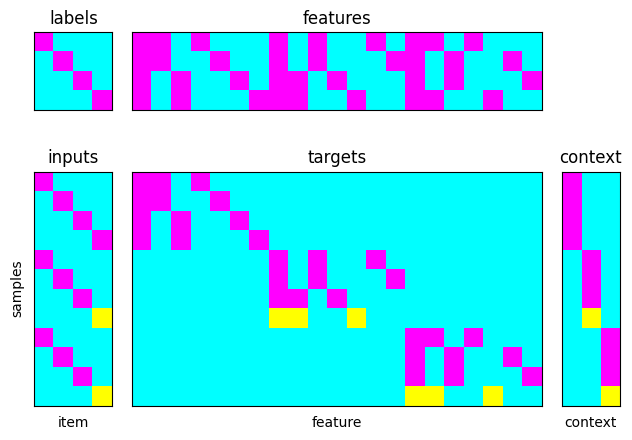

In [7]:
tree_labels, tree_features_all = du.hsd_context(n_items=dim_input, n_contexts=dim_context, 
                                                symmetry=symmetric_contexts)
label_tensor, feature_tensor, context_tensor = du.get_batch(tree_labels, tree_features_all, dim_context, 
                                                            separation=separate_contexts)

pf.plot_inputs_targets_contexts(label_tensor, feature_tensor, context_tensor, held_out, labels=tree_labels, 
                                features=tree_features_all)

1e-26


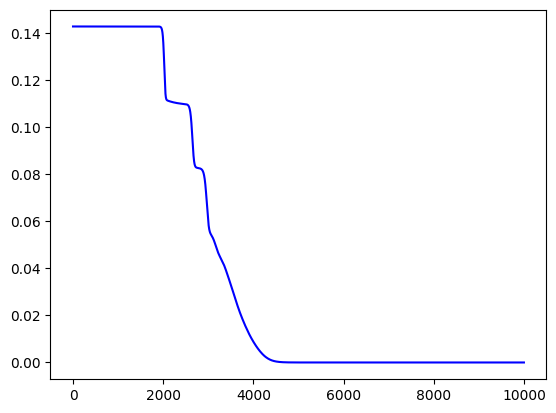

In [19]:
# Training
from GLNNet import train
lr = .5  # Learning rate
gamma = 1e-12 * 10**5 if len(dims) > 3 else 1e-26
print(gamma)
n_epochs = 10000

SEED = 2022
mu.set_seed(seed=SEED)

mu.initializer_(relunn_model, gamma)

losses, preds, rsms = train(relunn_model,
                  label_tensor,
                  feature_tensor,
                  context_tensor,
                  n_epochs=n_epochs,
                  lr=lr,
                  hold_out_i=held_out,
                  corr=True,
                  rsm_interval=1000)

plt.plot(losses, 'b')
plt.show()

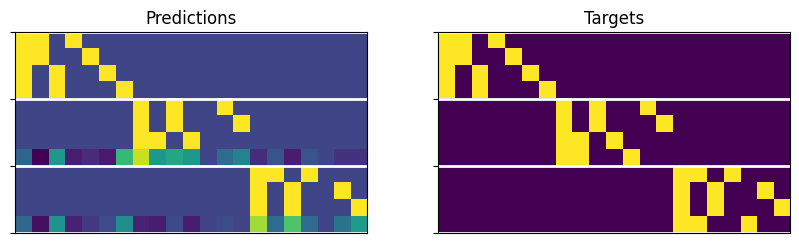

In [20]:
figsize = (10,4)

fig, axes = plt.subplots(1,2, figsize=figsize)
axes[0].imshow(preds[-1,:,:])
axes[0].title.set_text('Predictions')
axes[1].imshow(feature_tensor.detach().numpy())
axes[1].title.set_text('Targets')

for ax in axes:
    ax.set_yticks(ticks=np.arange(-.5, dim_input * dim_context, dim_input), labels=[], minor=False)
    ax.set_xticks(ticks=[], minor=False)
    ax.grid(which='major', color='w', linestyle='-', linewidth=2)

1


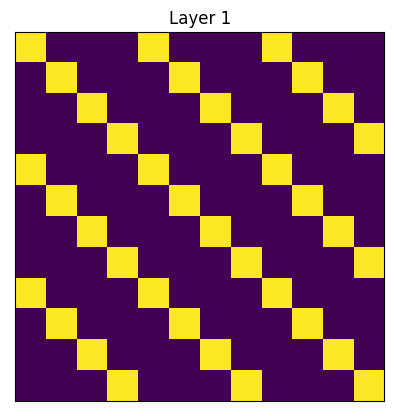

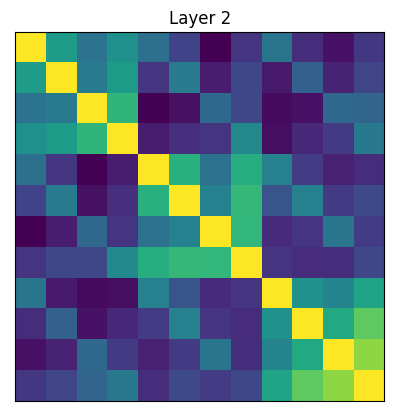

In [21]:
g = relunn_model.gateable_layers[0]
print(g)

t = -1

fig, ax = plt.subplots(1)
ax.imshow(rsms[g-1][0][t,:,:])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text('Layer 1')

fig, ax = plt.subplots(1)
ax.imshow(rsms[g][0][t,:,:])
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.title.set_text('Layer 2')
# plt.imshow(rsms[2][0])

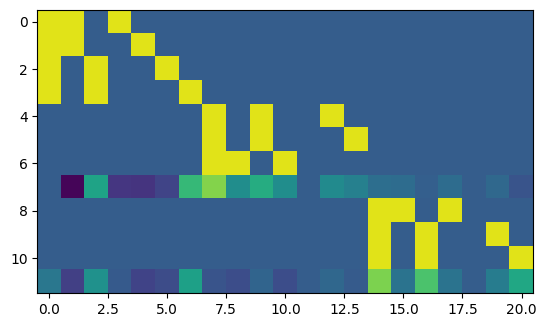

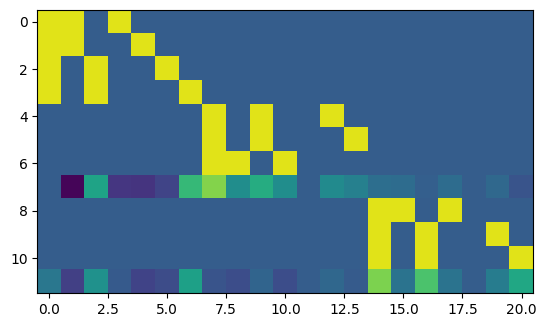

In [11]:
import matplotlib.animation
from IPython.display import display, clear_output

preds_ = preds
vmin, vmax = np.min(preds_), np.max(preds_)
n_frames = 500
iter_size = n_epochs // min(n_epochs, n_frames)

fig, ax = plt.subplots()
l = ax.imshow(preds_[0,:,:], vmin=vmin, vmax=vmax)

animate = lambda i: l.set_data(preds_[int(i),:,:])

for i in range(0, n_epochs, iter_size):
    animate(i)
    clear_output(wait=True)
    display(fig)